In [1]:
from os import path
import pandas as pd
from time import sleep
import radd
from radd import build, fit
from radd.tools import vis
%matplotlib inline

In [19]:
_homedir = path.expanduser('~')
# change this to wherever you have your data stored
coxon_data_path = path.join(_homedir, "Dropbox/Projects/Coxon/coxon_behav_data.csv")
# read data into pandas DataFrame (http://pandas.pydata.org/)
coxon_data = pd.read_csv(coxon_data_path)

# initiate dependent process model with dynamic gain (kind = 'xdpm')
# (change kind='dpm' for model with no dynamic gain signal)
# drift-rate (v) depends on Baseline and Caution levels of 'Cond' variable
dpm = build.Model(kind='xdpm', data=coxon_data, depends_on={'v':'Cond'}, fit_on='average')

# initiate independent race model with dynamic gain (kind = 'xirace')
# irm = build.Model(kind='xirace', data=coxon_data, depends_on={'v':'Cond'}, fit_on='average')

## Animation of Dependent Process Model

In [1]:
# Initial state of Stop process (red) depends on current strength of Go activation (green)
# Assumes Stop signal efficacy at later SSDs diminishes as the state of the Go process 
# approaches the execution threshold (upper bound). pink lines denote t=SSD, blue is trial deadline
radd.load_dpm_animation()

### columns in model's observed dataframe (model.observedDF)
* **idx**: subject ID
* **Cond**: Baseline(bsl)/Caution(pnl) (could be any experimental condition of interest) 
* **Acc**: Accuracy on "go" trials
* **sacc**: Mean accuracy on "stop" trials (mean condition SSD used during simulations)
* **c10 - c90**: 10th - 90th RT quantiles for correct responses
* **e10 - e90**: 10th - 90th RT quantiles for error responses

In [20]:
dpm.observedDF.head()

,idx,Cond,acc,sacc,c10,c30,c50,c70,c90,e10,e30,e50,e70,e90
0,1,pro,1.0,0.52500,0.76784,0.79500,0.8095,0.82400,0.84916,0.76066,0.77700,0.7895,0.80356,0.82402
1,1,reac,1.0,0.51613,0.76300,0.78300,0.7960,0.81634,0.84000,0.75642,0.76746,0.7850,0.79854,0.81216
2,2,pro,1.0,0.48750,0.78442,0.80200,0.8150,0.83500,0.85158,0.76300,0.78600,0.7970,0.81100,0.82200
3,2,reac,1.0,0.46774,0.78200,0.79800,0.8070,0.81914,0.83600,0.76500,0.77900,0.7890,0.80722,0.82800
4,3,pro,1.0,0.50000,0.77282,0.79366,0.8130,0.83500,0.86200,0.75310,0.78300,0.7945,0.81754,0.84812


## Optimize DPM to the Average Data

In [21]:
# Set basinhopping step-size to .1 (see HopStep class in radd.fit 
# and get_stepsize_scalars function in radd.tools.theta). 
# Sample 5000 possible parameters sets, perform global optimization on best 5
# then local optimization on lowest (best) 1 of 5 
dpm.set_basinparams(stepsize=.1, nrand_samples=5000, nrand_inits=5)

NEW GLOBAL MINIMUM: fmin_new=0.001463748; fmin_inits= 2.290467)
Finished Hopping Around


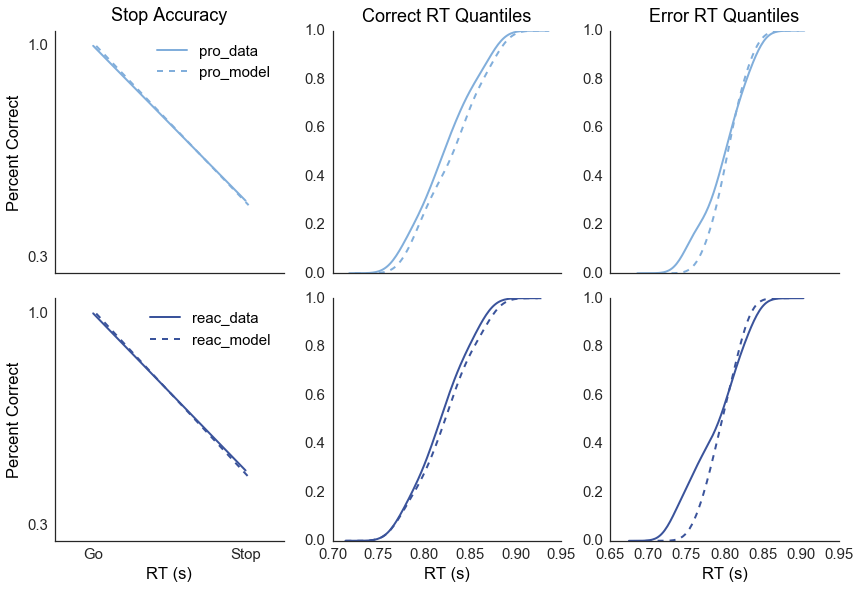

In [22]:
# fit DPM using combination of global (basinhopping + TNC)
# and local gradient optimization (Nelder-Mead Simplex)
# set progress=True to track global minimum across all (5) intit params
# as well as the fmin (basin) of the current global optimization process
# ("progress" output is erased after fits are run... you'll see it when you run this cell)
dpm.optimize(plot_fits=True, progress=True)

## Some Further Explanation...

* All models are initially fit to a flat data vector, weighted by an equal length array of weights estimated as the inverse of the measured uncertainty in each observed data point (flat meaning single-dimensional vector, collapsing across conditions)

* If the user supplies a **depends_on** dictionary when instantiating the model (see above), then all parameters from the initial (flat) fit are held constant except for the parameter in **depends_on.keys()** which is free to vary across levels of the condition in **depends_on.values()**. 
    * For instance, to fit a model with drift-rate free to vary across levels of 'Cond' (column in the data)            
        * depends_on = {'v': 'Cond'} 
   
* For **model** with **fit_on** = 'average' and **depends_on** = {**param** : **condition**}

|model information | method used to calculate | how to access|
|--|--|--|
| flat data | **model**.observedDF.mean() | **model**.observed_flat |
| flat weights | **model**.wtsDF.mean() | **model**.flat_wts |
| conditional data | **model**.observedDF.groupby(**condition**).mean()| **model**.observed |
| conditional weights | **model**.wtsDF.groupby(**condition**).mean() |  **model**.cond_wts |

## Troubleshooting Ugly Fits

* fit to individual subjects
    * model = build.Model(data=data, ..., **fit_on**=**'subjects'**)
* other models (currently only dpm and irace), 
    * the example above uses the dpm with dynamic rate bias (**kind**=**'xdpm'**)
    * to implement the independent race model with the same drift-rate dependency on Cond as above
        * model = build.Model(data=data, **kind**=**xirace'**, **depends_on**={**'v'**: **'Cond'**})
    * implement without dynamic bias (same "kind" without the 'x' )
        * model = build.Model(data=data, **kind**=**irace'**, **depends_on**={**'v'**: **'Cond'**})
        
* other dependencies, maybe subjects change their boundary height or go onset time across conditions
    * model with boundary free across conditions:
        * model = build.Model(data=data, ... , **depends_on**={**'a'**: **'Cond'**})
    * model with onset free across conditions:
        * model = build.Model(data=data, ... , **depends_on**={**'tr'**: **'Cond'**})
        
* increasing size of the parameters search and setting more conservative convergence criteria 
     * model.set_basinparams(niter_success=50, tol=1e6, nrand_inits=10, nrand_samples=10000) 
     * model.set_fitparams(maxfev=5000, tol=1e-6)
     * check out the wts vectors for extreme vals
         * try re-running the fits with an unweighted model (all wts = 1) 
             * m = build.Model(data=data, ... weighted=False)
     * sometimes error rts are particularly troublesome, sometimes un-shootably so...


### double check the mean ssd values for pro and reac conditions look right?
(important as these were used to simulate the model predictions entered into the cost_fx)

   * pro:  0.63064
   * reac: 0.62547


## Examine fits

In [26]:
# the fit summary (goodness of fit measures, etc.) 
dpm.fitDF

idx,average
a,0.49616
ssv,-1.587
tr,0.36931
xb,0.38719
v_pro,1.0563
v_reac,1.0736
nfev,1054
nvary,2
df,22
chi,0.0025573


In [27]:
# model predictions
# to save as csv file: dpm.yhatDF.to_csv("path_where_you_want_to_save_to", index=False)
# to extract values as numpy ndarray: dpm.yhatDF.loc[:, 'acc':].values
dpm.yhatDF

,idx,Cond,acc,sacc,c10,c30,c50,c70,c90,e10,e30,e50,e70,e90
0,average,pro,0.99955,0.4745,0.78431,0.80431,0.83431,0.84931,0.87931,0.77431,0.79431,0.80431,0.81431,0.83431
1,average,reac,0.99945,0.4604,0.77431,0.80431,0.82431,0.83931,0.86931,0.76431,0.78431,0.79431,0.81431,0.82431


In [28]:
# best-fit parameter estimates also stored in popt dictionary
dpm.popt

{'a': 0.49616400549857481,
 'ssv': -1.5869988922681091,
 'tr': 0.36930919593208855,
 'v': array([ 1.0563 ,  1.07361]),
 'v_pro': 1.0563037667368729,
 'v_reac': 1.0736084963145991,
 'xb': 0.38718618443682729}

In [20]:
def css_styling():
    import radd
    from IPython.core.display import HTML
    css_path = os.path.join(radd._examples_dir, 'custom.css')
    styles = open(css_path, "r").read()
    return HTML(styles)
css_styling()